In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

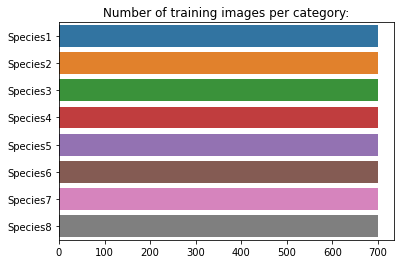

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [9]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1.]
Label: 7
Class name: Species8


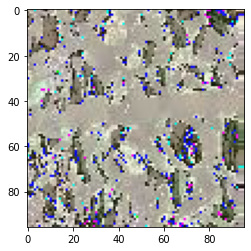

In [22]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('ResNet')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                          

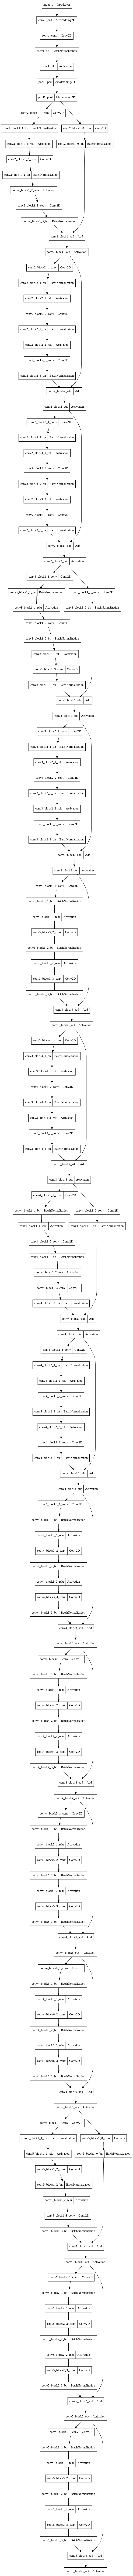

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
input_shape = (96, 96, 3)
epochs = 200

In [15]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [17]:
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [18]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 1.4509 - accuracy: 0.5380 - precision: 0.6298 - recall: 0.4298 

175/175 [==============================] - 2002s 11s/step - loss: 1.4509 - accuracy: 0.5380 - precision: 0.6298 - recall: 0.4298 - val_loss: 0.9723 - val_accuracy: 0.6641 - val_precision: 0.7621 - val_recall: 0.5655
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.6743 - precision: 0.7503 - recall: 0.5827

175/175 [==============================] - 51s 295ms/step - loss: 0.9243 - accuracy: 0.6743 - precision: 0.7503 - recall: 0.5827 - val_loss: 0.9336 - val_accuracy: 0.6869 - val_precision: 0.7692 - val_recall: 0.6262
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.7111 - precision: 0.7797 - recall: 0.6339

175/175 [==============================] - 53s 302ms/step - loss: 0.8164 - accuracy: 0.7111 - precision: 0.7797 - recall: 0.6339 - val_loss: 0.8535 - val_accuracy: 0.6945 - val_precision: 0.7428 - val_recall: 0.6357
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.7232 - precision: 0.7903 - recall: 0.6527

175/175 [==============================] - 52s 296ms/step - loss: 0.7674 - accuracy: 0.7232 - precision: 0.7903 - recall: 0.6527 - val_loss: 0.8310 - val_accuracy: 0.7268 - val_precision: 0.7669 - val_recall: 0.6679
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.7573 - precision: 0.8174 - recall: 0.6977

175/175 [==============================] - 52s 299ms/step - loss: 0.6855 - accuracy: 0.7573 - precision: 0.8174 - recall: 0.6977 - val_loss: 0.8107 - val_accuracy: 0.7116 - val_precision: 0.7722 - val_recall: 0.6755
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.7748 - precision: 0.8307 - recall: 0.7218

175/175 [==============================] - 50s 288ms/step - loss: 0.6392 - accuracy: 0.7748 - precision: 0.8307 - recall: 0.7218 - val_loss: 0.7893 - val_accuracy: 0.7419 - val_precision: 0.7948 - val_recall: 0.6983
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7889 - precision: 0.8382 - recall: 0.7354

175/175 [==============================] - 51s 291ms/step - loss: 0.6030 - accuracy: 0.7889 - precision: 0.8382 - recall: 0.7354 - val_loss: 0.8625 - val_accuracy: 0.7154 - val_precision: 0.7601 - val_recall: 0.6793
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7946 - precision: 0.8427 - recall: 0.7511

175/175 [==============================] - 51s 292ms/step - loss: 0.5663 - accuracy: 0.7946 - precision: 0.8427 - recall: 0.7511 - val_loss: 0.7925 - val_accuracy: 0.7230 - val_precision: 0.7895 - val_recall: 0.6831
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.7991 - precision: 0.8434 - recall: 0.7541

175/175 [==============================] - 52s 298ms/step - loss: 0.5617 - accuracy: 0.7991 - precision: 0.8434 - recall: 0.7541 - val_loss: 0.8069 - val_accuracy: 0.7343 - val_precision: 0.7710 - val_recall: 0.6964
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.8123 - precision: 0.8571 - recall: 0.7766

175/175 [==============================] - 51s 292ms/step - loss: 0.5129 - accuracy: 0.8123 - precision: 0.8571 - recall: 0.7766 - val_loss: 0.7213 - val_accuracy: 0.7666 - val_precision: 0.8080 - val_recall: 0.7268
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.8127 - precision: 0.8553 - recall: 0.7686

175/175 [==============================] - 51s 293ms/step - loss: 0.5274 - accuracy: 0.8127 - precision: 0.8553 - recall: 0.7686 - val_loss: 0.8012 - val_accuracy: 0.7552 - val_precision: 0.7929 - val_recall: 0.7192
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.8257 - precision: 0.8659 - recall: 0.7855

175/175 [==============================] - 52s 295ms/step - loss: 0.4977 - accuracy: 0.8257 - precision: 0.8659 - recall: 0.7855 - val_loss: 0.7395 - val_accuracy: 0.7704 - val_precision: 0.8102 - val_recall: 0.7211
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.8341 - precision: 0.8711 - recall: 0.8036

175/175 [==============================] - 50s 288ms/step - loss: 0.4662 - accuracy: 0.8341 - precision: 0.8711 - recall: 0.8036 - val_loss: 0.7536 - val_accuracy: 0.7552 - val_precision: 0.8054 - val_recall: 0.7306
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8425 - precision: 0.8760 - recall: 0.8061

175/175 [==============================] - 51s 292ms/step - loss: 0.4597 - accuracy: 0.8425 - precision: 0.8760 - recall: 0.8061 - val_loss: 0.7417 - val_accuracy: 0.7552 - val_precision: 0.7830 - val_recall: 0.7324
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8370 - precision: 0.8682 - recall: 0.8034

175/175 [==============================] - 51s 291ms/step - loss: 0.4781 - accuracy: 0.8370 - precision: 0.8682 - recall: 0.8034 - val_loss: 0.7438 - val_accuracy: 0.7590 - val_precision: 0.7885 - val_recall: 0.7287
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8521 - precision: 0.8824 - recall: 0.8204

175/175 [==============================] - 51s 293ms/step - loss: 0.4236 - accuracy: 0.8521 - precision: 0.8824 - recall: 0.8204 - val_loss: 0.7555 - val_accuracy: 0.7666 - val_precision: 0.7818 - val_recall: 0.7343
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8441 - precision: 0.8778 - recall: 0.8155

175/175 [==============================] - 50s 289ms/step - loss: 0.4456 - accuracy: 0.8441 - precision: 0.8778 - recall: 0.8155 - val_loss: 0.7499 - val_accuracy: 0.7533 - val_precision: 0.8008 - val_recall: 0.7324
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8482 - precision: 0.8808 - recall: 0.8191

175/175 [==============================] - 52s 298ms/step - loss: 0.4335 - accuracy: 0.8482 - precision: 0.8808 - recall: 0.8191 - val_loss: 0.7519 - val_accuracy: 0.7514 - val_precision: 0.7875 - val_recall: 0.7173
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8541 - precision: 0.8832 - recall: 0.8275

175/175 [==============================] - 50s 289ms/step - loss: 0.4071 - accuracy: 0.8541 - precision: 0.8832 - recall: 0.8275 - val_loss: 0.7824 - val_accuracy: 0.7400 - val_precision: 0.7805 - val_recall: 0.7154
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8532 - precision: 0.8829 - recall: 0.8280

175/175 [==============================] - 51s 291ms/step - loss: 0.4185 - accuracy: 0.8532 - precision: 0.8829 - recall: 0.8280 - val_loss: 0.8071 - val_accuracy: 0.7571 - val_precision: 0.7899 - val_recall: 0.7419
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8537 - precision: 0.8852 - recall: 0.8289

175/175 [==============================] - 49s 281ms/step - loss: 0.4144 - accuracy: 0.8537 - precision: 0.8852 - recall: 0.8289 - val_loss: 0.7947 - val_accuracy: 0.7666 - val_precision: 0.7967 - val_recall: 0.7362
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8627 - precision: 0.8929 - recall: 0.8339

175/175 [==============================] - 51s 291ms/step - loss: 0.3961 - accuracy: 0.8627 - precision: 0.8929 - recall: 0.8339 - val_loss: 0.8450 - val_accuracy: 0.7514 - val_precision: 0.7860 - val_recall: 0.7249


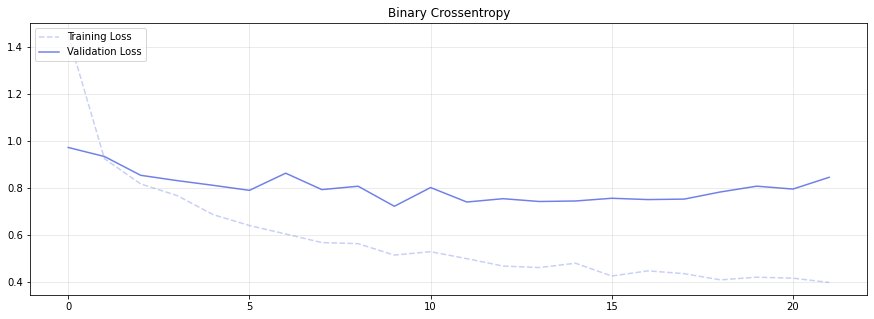

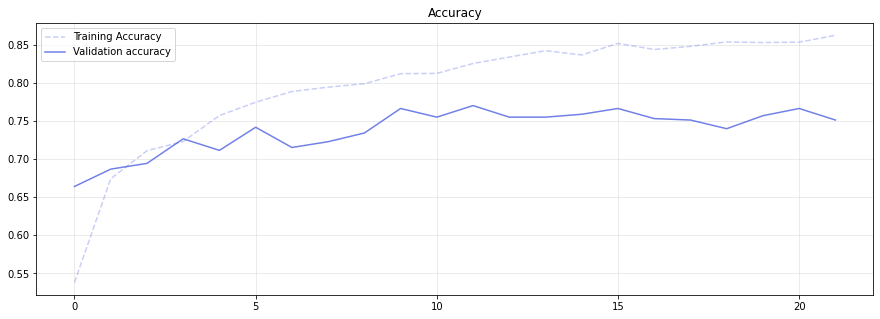

In [19]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [20]:
tl_model.save('ResNet/tl_model_v1')

In [21]:
tl_model = tfk.models.load_model('ResNet/tl_model_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [24]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [26]:
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:150]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [27]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [28]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 34s 170ms/step - loss: 0.8610 - accuracy: 0.7468 - precision_1: 0.7893 - recall_1: 0.7123 - val_loss: 0.9108 - val_accuracy: 0.7154 - val_precision_1: 0.7526 - val_recall_1: 0.6869
Epoch 2/200
175/175 [==============================] - 29s 165ms/step - loss: 0.5303 - accuracy: 0.8168 - precision_1: 0.8580 - recall_1: 0.7780 - val_loss: 0.9302 - val_accuracy: 0.7287 - val_precision_1: 0.7587 - val_recall_1: 0.7040
Epoch 3/200
175/175 [==============================] - 25s 142ms/step - loss: 0.4357 - accuracy: 0.8502 - precision_1: 0.8849 - recall_1: 0.8211 - val_loss: 0.8607 - val_accuracy: 0.7419 - val_precision_1: 0.7838 - val_recall_1: 0.7154
Epoch 4/200
175/175 [==============================] - 26s 146ms/step - loss: 0.4033 - accuracy: 0.8682 - precision_1: 0.8993 - recall_1: 0.8386 - val_loss: 0.8160 - val_accuracy: 0.7419 - val_precision_1: 0.7792 - val_recall_1: 0.7097
Epoch 5/200
175/175 [==============================] - 2

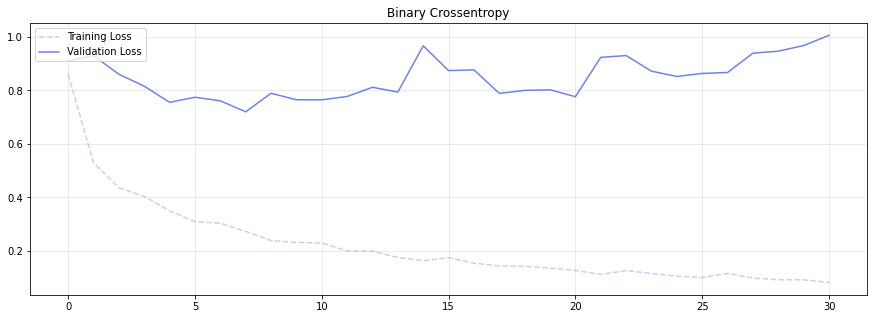

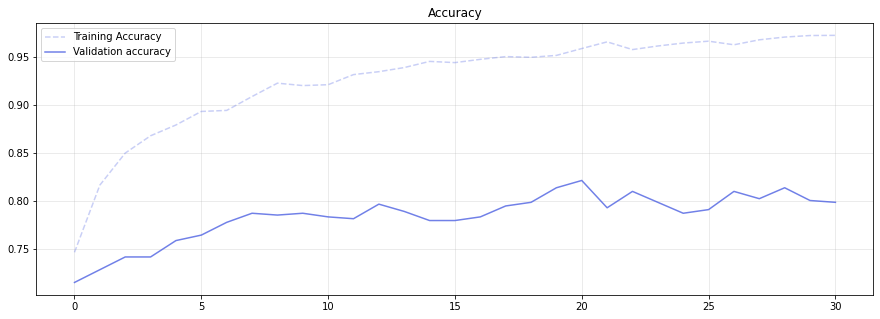

In [29]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [30]:
tl_model.save('ResNet/Tuned_150layers')

In [31]:
# Test the model
tl_model = tfk.models.load_model("ResNet/Tuned_150layers")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 111s 10s/step - loss: 0.8148 - accuracy: 0.8116 - precision_1: 0.8202 - recall_1: 0.8089

Test metrics
{'loss': 0.814789354801178, 'accuracy': 0.811634361743927, 'precision_1': 0.8202247023582458, 'recall_1': 0.8088642954826355}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8116
Precision: 0.7986
Recall: 0.7819
F1: 0.7882


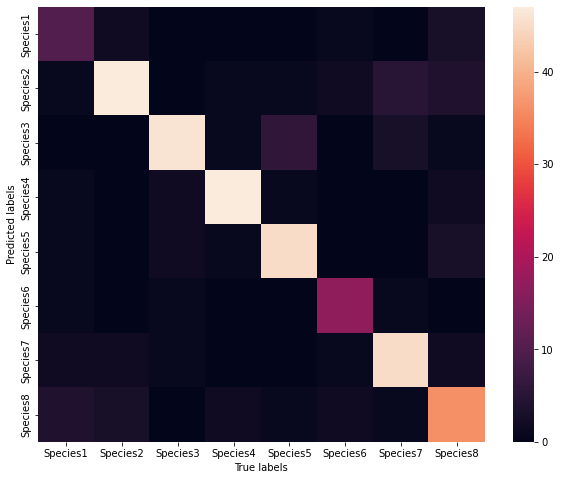

In [32]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()